In [1]:
import csv

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
# from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction import DictVectorizer

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
# from sklearn.cross_validation import train_test_split

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load training data
raw_train_data = pd.read_csv('../data/train.csv', parse_dates = ['Dates'], date_parser = pd.datetools.to_datetime)
raw_train_data['CategoryNum'] = raw_train_data['Category'].astype("category").cat.codes
raw_train_data['DistrictNum'] = raw_train_data['PdDistrict'].astype('category').cat.codes
raw_train_data['Year'] = raw_train_data['Dates'].apply(lambda s: s.year)
raw_train_data['Month'] = raw_train_data['Dates'].apply(lambda s: s.month)
raw_train_data['DayNum'] = raw_train_data['Dates'].apply(lambda s: s.isoweekday())
raw_train_data.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,CategoryNum,DistrictNum,Year,Month,DayNum
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,37,4,2015,5,3
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,21,4,2015,5,3
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,21,4,2015,5,3
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,16,4,2015,5,3
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,16,5,2015,5,3


In [3]:
# Load test data
test_data = pd.read_csv('../data/test.csv', parse_dates = ['Dates'], date_parser = pd.datetools.to_datetime)
test_data.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [4]:
train_data = raw_train_data.loc[:,['Dates','Year','Month','DayOfWeek','DayNum','PdDistrict','DistrictNum','Address','X','Y']]
train_data.head()

,Dates,Year,Month,DayOfWeek,DayNum,PdDistrict,DistrictNum,Address,X,Y
0,2015-05-13 23:53:00,2015,5,Wednesday,3,NORTHERN,4,OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,2015,5,Wednesday,3,NORTHERN,4,OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,2015,5,Wednesday,3,NORTHERN,4,VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,2015,5,Wednesday,3,NORTHERN,4,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,2015,5,Wednesday,3,PARK,5,100 Block of BRODERICK ST,-122.438738,37.771541


In [5]:
train_data.describe()

,Year,Month,DayNum,DistrictNum,X,Y
count,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000
mean,2008.712046,6.436509,3.992691,4.445310,-122.422616,37.771020
std,3.631194,3.428972,1.972023,2.863715,0.030354,0.456893
min,2003.000000,1.000000,1.000000,0.000000,-122.513642,37.707879
25%,2006.000000,3.000000,2.000000,2.000000,-122.432952,37.752427
50%,2009.000000,6.000000,4.000000,4.000000,-122.416420,37.775421
75%,2012.000000,9.000000,6.000000,7.000000,-122.406959,37.784369
max,2015.000000,12.000000,7.000000,9.000000,-120.500000,90.000000


In [6]:
train_labels = pd.Series(raw_train_data.loc[:,'Category'].astype("category"))
train_labels.head()

0          WARRANTS
1    OTHER OFFENSES
2    OTHER OFFENSES
3     LARCENY/THEFT
4     LARCENY/THEFT
Name: Category, dtype: category
Categories (39, object): [ARSON, ASSAULT, BAD CHECKS, BRIBERY, ..., VANDALISM, VEHICLE THEFT, WARRANTS, WEAPON LAWS]

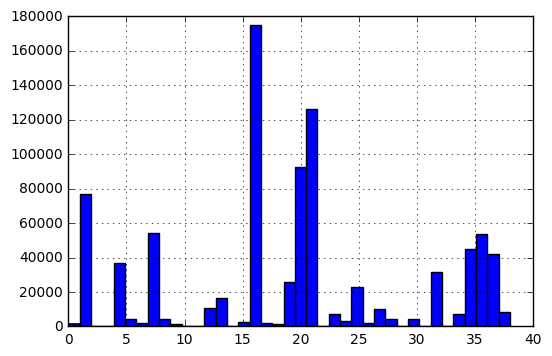

In [7]:
label_data = pd.DataFrame({'Category': raw_train_data.loc[:,'Category'].astype('category')})
train_labels.cat.codes.hist(bins=39)

In [8]:
# Determine the total occurrences of each category given a DoW/district combination
plot_data = pd.DataFrame({'DistrictNum': raw_train_data.loc[:,'DistrictNum'],
                          'CategoryNum': raw_train_data.loc[:,'CategoryNum'],
                          'DayNum': raw_train_data.loc[:,'DayNum']})
plot_data['Quantity'] = [1] * len(plot_data.loc[:,'DistrictNum'])
agg_plot_data = plot_data.groupby(['DayNum', 'DistrictNum', 'CategoryNum'])
plot_data['Counts'] = agg_plot_data.transform(sum)
plot_data['DayDistrict'] = plot_data.apply(lambda r: r['DayNum'] * 10 + r['DistrictNum'], axis=1)
plot_data.head()

,CategoryNum,DayNum,DistrictNum,Quantity,Counts,DayDistrict
0,37,3,4,1,733,34
1,21,3,4,1,1995,34
2,21,3,4,1,1995,34
3,16,3,4,1,3956,34
4,16,3,5,1,1285,35


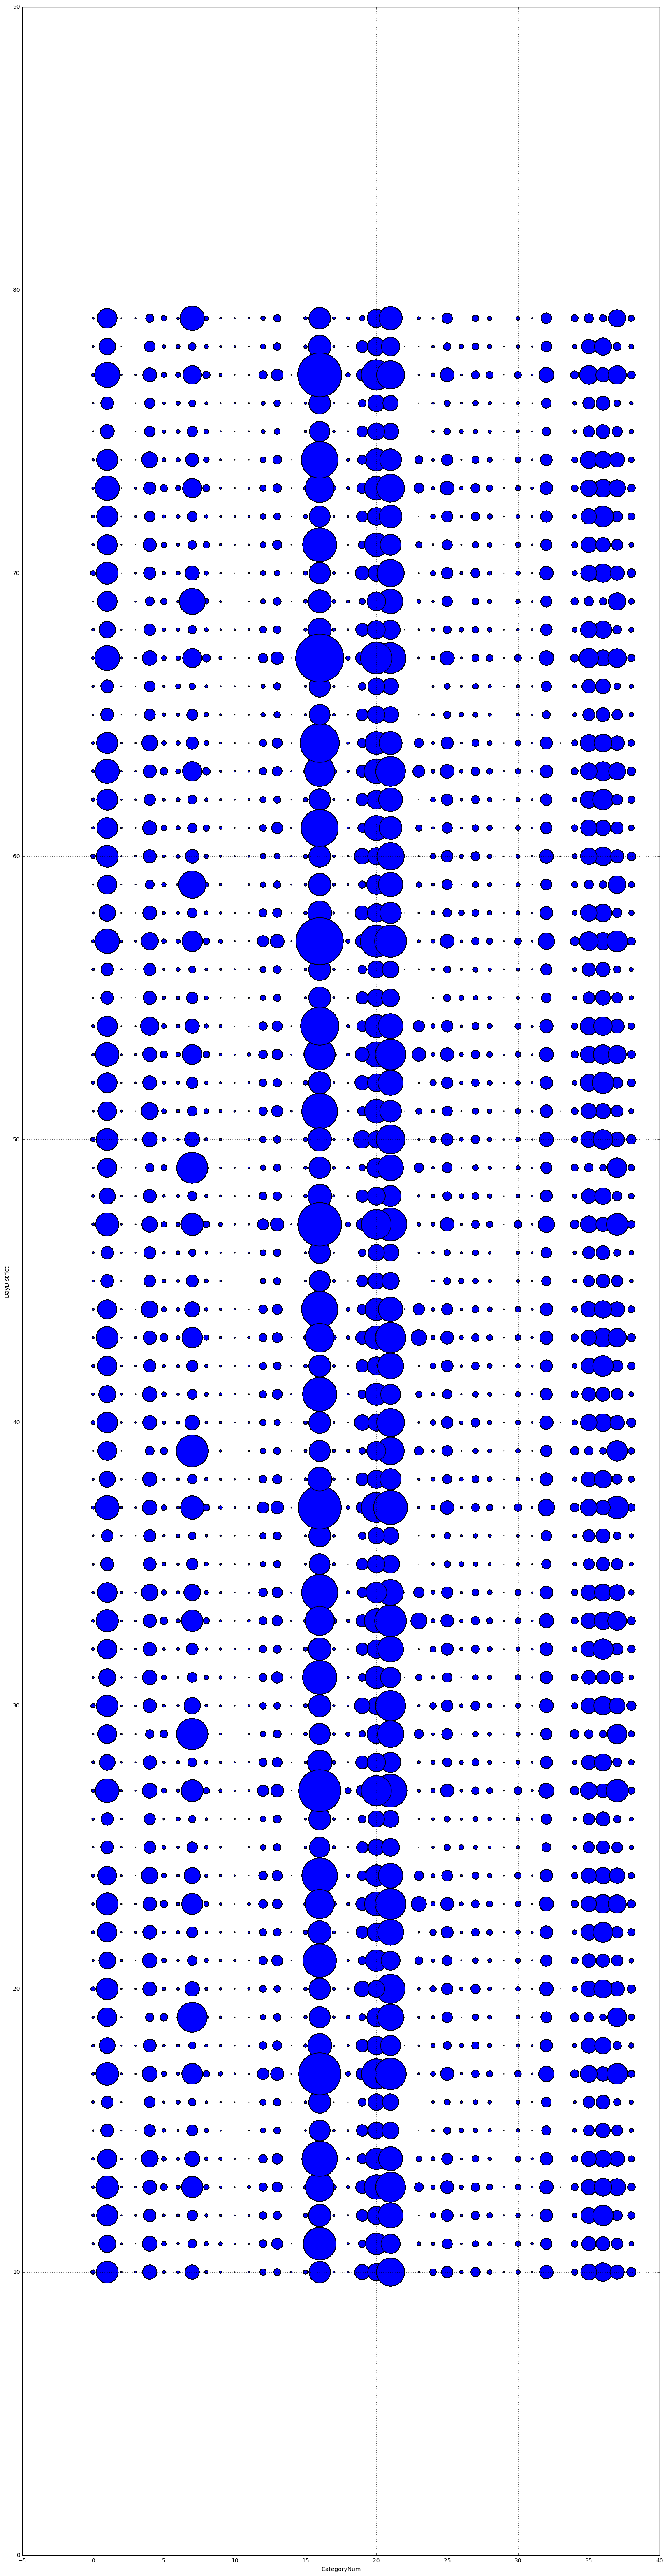

In [9]:
# The size of a circle represents the occurrence count.
# x-axis covers the 39 categories.
# y-axis is the combination of "day of the week" and "district" represented in 2 digits.
# The scattered plot shows that there is no correlation between category and day of the week.
# The scattered plot shows that there is some correlation between category and district.
plot_data.plot(kind='scatter', y='DayDistrict', x='CategoryNum', s=plot_data['Counts'], grid=True, figsize=(20,80))

In [ ]:
# X_train, X_dev, y_train, y_dev = train_test_split(train_data.loc[:,['DayNum', 'DistrictNum']], train_labels, test_size = 0.2, random_state = 0)
# X_train.head()

In [ ]:
# clf = LogisticRegression()
# clf.fit(X_train, y_train)
# predicted_y_dev = clf.predict(X_dev)
# for i in range(10):
#     print("{} {}".format(y_dev[i], predicted_y_dev[i]))